## Train and Prediction on all data

Using rotated to hz + OpenCv border

Basic default transforms

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
import geopandas as gpd
from resizeimage import resizeimage
import datetime
import uuid
from os import listdir
from os.path import isfile, join
from radam import *

In [3]:
torch.cuda.set_device(0)
torch.cuda.current_device()

0

In [4]:
data_dir = Path('data')

In [5]:
RETRAIN = True
RESIZE_IMAGES = True

In [6]:
MODEL_NAME='cv_reflect_101_radam'

In [7]:
NB_NUM='03_13'

In [8]:
DATE = datetime.datetime.today().strftime('%Y%m%d')
UID=str(uuid.uuid4())[:8]
print(f'UID: {UID}, DATE: {DATE}')                                                 

UID: d95b4607, DATE: 20191110


In [9]:
#DATE = '20191026'
#UID = '1964891c'

In [10]:
SUB_NUM='17'

In [11]:
img_size=256

In [12]:
train_images=data_dir/f'train/rotated/clipped/reflect/{img_size}'
test_images=data_dir/f'test/rotated/clipped/reflect/{img_size}'

In [13]:
test_names = get_image_files(test_images)

In [14]:
assert len(test_names)==7325

In [15]:
df_all=pd.read_csv(data_dir/'df_train_all.csv')

In [16]:
df_all.tail()

,id,roof_material,verified,country,region
22548,7a22ddec,healthy_metal,False,st_lucia,gros_islet
22549,7a2f73ea,healthy_metal,False,st_lucia,gros_islet
22550,7a34ffa4,healthy_metal,False,st_lucia,gros_islet
22551,7a41560a,healthy_metal,False,st_lucia,gros_islet
22552,7a283ad0,healthy_metal,False,st_lucia,gros_islet


In [17]:
df_all=df_all.drop_duplicates(subset=['id'])

In [18]:
df_test=pd.read_csv(data_dir/'df_test_all.csv')

In [19]:
df_test.tail()

,id,country,region
7320,7a4f3ff4,st_lucia,dennery
7321,7a4fc578,st_lucia,dennery
7322,7a4ac7b2,st_lucia,dennery
7323,7a47e25e,st_lucia,dennery
7324,7a4e3f78,st_lucia,dennery


In [20]:
assert len(df_test)==7325

In [21]:
len(df_all)

22553

To put this in a `DataBunch` while using the [data block API](https://docs.fast.ai/data_block.html), we then need to using `ImageList` (and not `ImageDataBunch`). This will make sure the model created has the proper loss function to deal with the multiple classes.

In [22]:
tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

### setup dataset

In [23]:
np.random.seed(42)
dep_var='roof_material'
src = (ImageList.from_df(path=train_images, df=df_all, cols='id', suffix='.tif')
       .split_by_rand_pct(0.2)
      .label_from_df(cols=dep_var)
      .add_test_folder(test_images))

In [24]:
data = (src.transform(tfms, size=img_size)
        .databunch().normalize(imagenet_stats))

In [25]:
#to check what params object has
#dir(data)

In [26]:
data.label_list

LabelLists;

Train: LabelList (18043 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
concrete_cement,irregular_metal,healthy_metal,healthy_metal,healthy_metal
Path: data/train/rotated/clipped/reflect/256;

Valid: LabelList (4510 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
irregular_metal,healthy_metal,healthy_metal,irregular_metal,healthy_metal
Path: data/train/rotated/clipped/reflect/256;

Test: LabelList (0 items)
x: ImageList

y: EmptyLabelList

Path: data/train/rotated/clipped/reflect/256

In [27]:
data.loss_func

FlattenedLoss of CrossEntropyLoss()

`show_batch` still works, and show us the different labels separated by `;`.

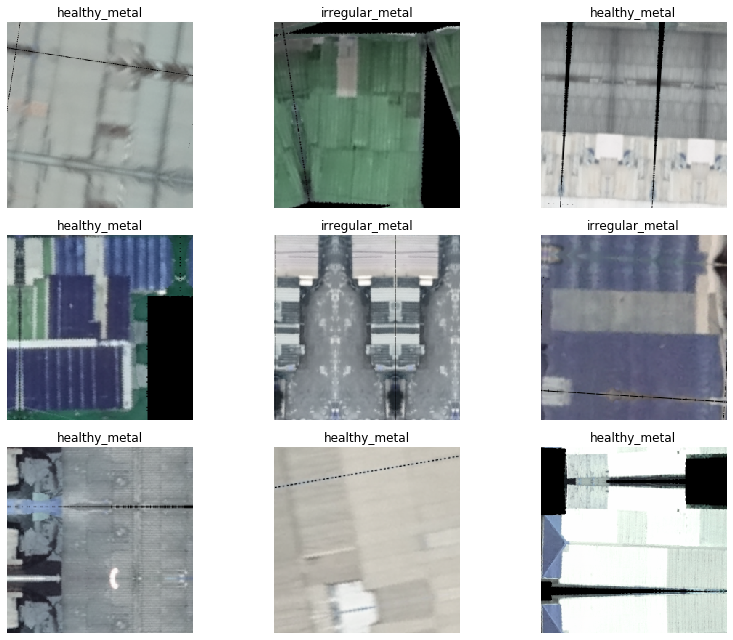

In [28]:
data.show_batch(rows=3, figsize=(12,9))

### Model

In [29]:
arch = models.resnet50
arch_name = 'rn50'

In [30]:
optar = partial(RAdam)

In [31]:
learn = cnn_learner(data, arch, opt_func=optar, metrics=error_rate, bn_final=True).to_fp16()

We use the LR Finder to pick a good learning rate.

### (Re)train model

In [32]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


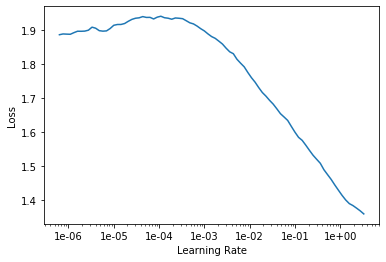

In [33]:
learn.recorder.plot()

Then we can fit the head of our network.

In [34]:
lr = 1e-2

In [35]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,error_rate,time
0,1.008295,0.874984,0.232373,01:23
1,0.616419,0.536606,0.168958,01:23
2,0.493867,0.455243,0.156984,01:23
3,0.446465,0.431327,0.147228,01:23
4,0.421189,0.426287,0.147672,01:20


<pre>
Adam
 epoch 	train_loss 	valid_loss 	error_rate 	time
0 	0.508273 	1.170024 	0.339911 	01:16
1 	0.471699 	0.494651 	0.166297 	01:22
2 	0.439157 	0.417086 	0.152328 	01:23
3 	0.402381 	0.370002 	0.127938 	01:23
4 	0.355355 	0.360440 	0.126608 	01:22
</pre>

In [36]:
learn.save(f'stage-1-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}')


#### Load model

In [37]:
learn.load(f'stage-1-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}')

Learner(data=ImageDataBunch;

Train: LabelList (18043 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
concrete_cement,irregular_metal,healthy_metal,healthy_metal,healthy_metal
Path: data/train/rotated/clipped/reflect/256;

Valid: LabelList (4510 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
irregular_metal,healthy_metal,healthy_metal,irregular_metal,healthy_metal
Path: data/train/rotated/clipped/reflect/256;

Test: LabelList (0 items)
x: ImageList

y: EmptyLabelList

Path: data/train/rotated/clipped/reflect/256, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=

In [38]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,error_rate,time
0,0.409112,0.429916,0.150333,01:08
1,0.409500,0.394467,0.142794,01:05
2,0.378414,0.377760,0.132372,01:01
3,0.368458,0.367413,0.131929,01:05
4,0.350582,0.365026,0.130377,01:03


In [39]:
interp = ClassificationInterpretation.from_learner(learn)
interp.most_confused(min_val=2)

[('irregular_metal', 'healthy_metal', 215),
 ('healthy_metal', 'irregular_metal', 117),
 ('incomplete', 'irregular_metal', 55),
 ('other', 'healthy_metal', 37),
 ('concrete_cement', 'healthy_metal', 31),
 ('incomplete', 'healthy_metal', 25),
 ('healthy_metal', 'concrete_cement', 24),
 ('irregular_metal', 'concrete_cement', 24),
 ('incomplete', 'concrete_cement', 16),
 ('irregular_metal', 'incomplete', 11),
 ('concrete_cement', 'irregular_metal', 10),
 ('other', 'irregular_metal', 7),
 ('concrete_cement', 'incomplete', 6),
 ('healthy_metal', 'incomplete', 3),
 ('irregular_metal', 'other', 3),
 ('concrete_cement', 'other', 2)]

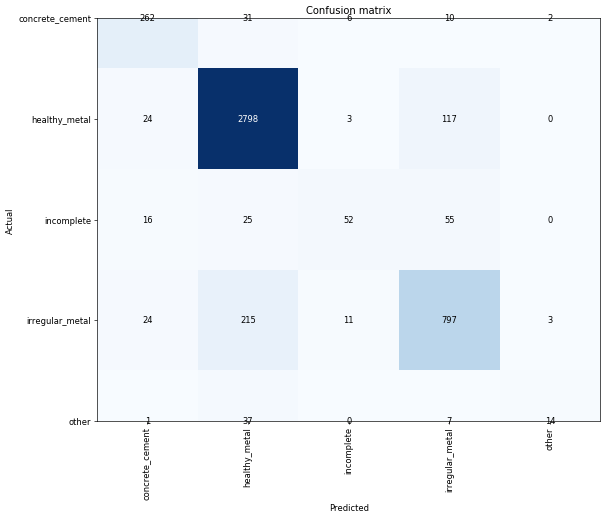

In [40]:
interp.plot_confusion_matrix(figsize=(10,10), dpi=60)

### Re-train

In [41]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


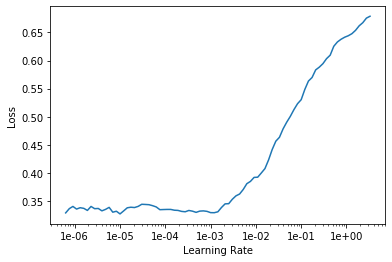

In [42]:
learn.lr_find()
learn.recorder.plot()

In [43]:
learn.fit_one_cycle(5, slice(1e-5, lr/5))

epoch,train_loss,valid_loss,error_rate,time
0,0.345445,0.381400,0.133481,01:32
1,0.357706,0.382828,0.137472,01:30
2,0.339114,0.363528,0.131042,01:31
3,0.299223,0.352882,0.126386,01:25
4,0.252422,0.353034,0.130155,01:22


<pre>
epoch 	train_loss 	valid_loss 	error_rate 	time
0 	0.438103 	0.431031 	0.157428 	01:37
1 	0.413694 	0.500094 	0.179823 	01:38
2 	0.405334 	0.394548 	0.143902 	01:35
3 	0.400567 	0.368481 	0.135920 	01:35
4 	0.352880 	0.357799 	0.128381 	01:35
    </pre>

In [44]:
learn.save(f'stage-2-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}')

In [45]:
learn.load(f'stage-2-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}')

Learner(data=ImageDataBunch;

Train: LabelList (18043 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
concrete_cement,irregular_metal,healthy_metal,healthy_metal,healthy_metal
Path: data/train/rotated/clipped/reflect/256;

Valid: LabelList (4510 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
irregular_metal,healthy_metal,healthy_metal,irregular_metal,healthy_metal
Path: data/train/rotated/clipped/reflect/256;

Test: LabelList (0 items)
x: ImageList

y: EmptyLabelList

Path: data/train/rotated/clipped/reflect/256, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=

In [46]:
learn.fit_one_cycle(5, slice(1e-5, lr/5))

epoch,train_loss,valid_loss,error_rate,time
0,0.254634,0.371603,0.127716,01:31
1,0.313594,0.382977,0.134368,01:27
2,0.283258,0.383178,0.139246,01:17
3,0.227149,0.377218,0.134590,01:22
4,0.180931,0.382345,0.135698,01:31


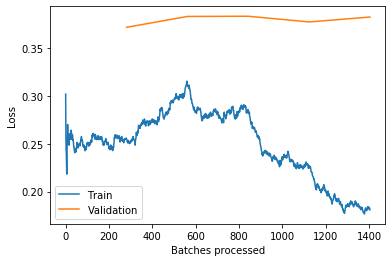

In [47]:
learn.recorder.plot_losses()

In [35]:
learn.save(f'stage-2-1-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}')

In [48]:
learn.load(f'stage-2-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}')

Learner(data=ImageDataBunch;

Train: LabelList (18043 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
concrete_cement,irregular_metal,healthy_metal,healthy_metal,healthy_metal
Path: data/train/rotated/clipped/reflect/256;

Valid: LabelList (4510 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
irregular_metal,healthy_metal,healthy_metal,irregular_metal,healthy_metal
Path: data/train/rotated/clipped/reflect/256;

Test: LabelList (0 items)
x: ImageList

y: EmptyLabelList

Path: data/train/rotated/clipped/reflect/256, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=

In [49]:
learn=learn.to_fp32()

In [50]:
learn.export(f'stage-2-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}.pkl')

In [51]:
learn.export()

### inference

In [52]:
#test_images=data_dir/f'test/rotated/clipped/{img_size}'
test_dataset=ImageList.from_folder(test_images)

In [53]:
len(test_dataset)

7325

In [54]:
learn = load_learner(path=data_dir/f'train/rotated/clipped/reflect/{img_size}', test=test_dataset)

In [55]:
#learn = load_learner(path=data_dir/f'train/rotated/clipped/{img_size}', file=f'stage-2-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}.pkl', test=test_dataset)

In [56]:
learn.data.loss_func

FlattenedLoss of CrossEntropyLoss()

In [57]:
type(learn.data)

fastai.vision.data.ImageDataBunch

In [58]:
type(learn.dl(DatasetType.Test))

fastai.basic_data.DeviceDataLoader

In [59]:
len(learn.dl(DatasetType.Test))

115

Get number of items in the Valid dataset (in DeviceDataLoader)

In [60]:
#assert len(learn.dl(DatasetType.Test).dl)==7325

Required format:
    
<pre>
id	concrete_cement	healthy_metal	incomplete	irregular_metal	other
7a4d630a	0.9	0	0	0	0
7a4bbbd6	0.9	0	0	0	0
7a4ac744	0.9	0	0	0	0
7a4881fa	0.9	0	0	0	0
7a4aa4a8	0.9	0	0	0	0
</pre>


In [61]:
preds,y= learn.get_preds(ds_type=DatasetType.Test)

In [62]:
labels = np.argmax(preds, 1)

In [63]:
len(preds)

7325

In [64]:
preds[0].tolist()

[0.0663502961397171,
 0.9157067537307739,
 0.0038574773352593184,
 0.008630210533738136,
 0.005455248989164829]

In [65]:
preds_list=[]
for pred in preds:
    preds_list.append(pred.tolist())

In [66]:
len(labels)

7325

In [67]:
learn.data.classes

['concrete_cement', 'healthy_metal', 'incomplete', 'irregular_metal', 'other']

In [68]:
data.classes

['concrete_cement', 'healthy_metal', 'incomplete', 'irregular_metal', 'other']

In [69]:
test_predictions = [learn.data.classes[int(x)] for x in labels]

In [70]:
test_predictions[0]

'healthy_metal'

In [71]:
type(learn.data.test_ds)

fastai.data_block.LabelList

In [72]:
 learn.data.test_ds.x.items

array([PosixPath('data/test/rotated/clipped/reflect/256/7a4d9168.tif'),
       PosixPath('data/test/rotated/clipped/reflect/256/7a4ae922.tif'),
       PosixPath('data/test/rotated/clipped/reflect/256/7a48ca98.tif'),
       PosixPath('data/test/rotated/clipped/reflect/256/7a49c614.tif'), ...,
       PosixPath('data/test/rotated/clipped/reflect/256/7a486800.tif'),
       PosixPath('data/test/rotated/clipped/reflect/256/7a4c49fc.tif'),
       PosixPath('data/test/rotated/clipped/reflect/256/7a501f50.tif'),
       PosixPath('data/test/rotated/clipped/reflect/256/7a4d27b4.tif')], dtype=object)

In [73]:
ids=[]
for item in learn.data.test_ds.x.items:
    base, id = os.path.split(item)
    id = id.split('.tif')[0]
    ids.append(id)

In [74]:
preds_list[0]

[0.0663502961397171,
 0.9157067537307739,
 0.0038574773352593184,
 0.008630210533738136,
 0.005455248989164829]

In [75]:
cols = learn.data.classes.copy()
cols.insert(0,'id')
df = pd.DataFrame(list(zip(ids, preds_list)), 
               columns =['id', 'pred']) 

In [76]:
cols

['id',
 'concrete_cement',
 'healthy_metal',
 'incomplete',
 'irregular_metal',
 'other']

In [77]:
df.head()

,id,pred
0,7a4d9168,"[0.0663502961397171, 0.9157067537307739, 0.003..."
1,7a4ae922,"[0.006429831963032484, 0.9537612795829773, 0.0..."
2,7a48ca98,"[0.010512406006455421, 0.2685326039791107, 0.0..."
3,7a49c614,"[0.0019648894667625427, 0.9536699652671814, 0...."
4,7a4dd4f2,"[0.003917001187801361, 0.9051680564880371, 0.0..."


In [78]:
pred_df = pd.DataFrame(df['pred'].values.tolist())

In [79]:
pred_df.insert(loc=0, column='id', value=ids)

In [80]:
pred_df.columns = cols

In [81]:
pred_df.head()

,id,concrete_cement,healthy_metal,incomplete,irregular_metal,other
0,7a4d9168,0.066350,0.915707,0.003857,0.008630,0.005455
1,7a4ae922,0.006430,0.953761,0.002208,0.033847,0.003754
2,7a48ca98,0.010512,0.268533,0.018738,0.695527,0.006689
3,7a49c614,0.001965,0.953670,0.002108,0.039250,0.003007
4,7a4dd4f2,0.003917,0.905168,0.002541,0.075705,0.012669


Required format:
    
<pre>
id	concrete_cement	healthy_metal	incomplete	irregular_metal	other
7a4d630a	0.9	0	0	0	0
7a4bbbd6	0.9	0	0	0	0
7a4ac744	0.9	0	0	0	0
7a4881fa	0.9	0	0	0	0
7a4aa4a8	0.9	0	0	0	0
</pre>


In [82]:
pred_ids=pred_df['id'].values.tolist()

In [83]:
df_baseline = pd.read_csv(data_dir/f'submissions/mean_baseline.csv')

In [84]:
df_baseline.head()

,id,concrete_cement,healthy_metal,incomplete,irregular_metal,other
0,7a4d630a,0.093275,0.496369,0.044923,0.352455,0.012979
1,7a4bbbd6,0.093275,0.496369,0.044923,0.352455,0.012979
2,7a4ac744,0.093275,0.496369,0.044923,0.352455,0.012979
3,7a4881fa,0.093275,0.496369,0.044923,0.352455,0.012979
4,7a4aa4a8,0.093275,0.496369,0.044923,0.352455,0.012979


In [85]:
baseline_ids=df_baseline['id'].values.tolist()

In [86]:
baseline_ids

['7a4d630a',
 '7a4bbbd6',
 '7a4ac744',
 '7a4881fa',
 '7a4aa4a8',
 '7a514434',
 '7a485f72',
 '7a4b8d32',
 '7a47eb3c',
 '7a4be3ae',
 '7a46a330',
 '7a481620',
 '7a49c678',
 '7a4ea044',
 '7a47aa1e',
 '7a51aa1e',
 '7a498be0',
 '7a4a2848',
 '7a4c4cd6',
 '7a465038',
 '7a4e94aa',
 '7a49f62a',
 '7a45b6f0',
 '7a50bb90',
 '7a4d38e4',
 '7a48a3a6',
 '7a4ebe9e',
 '7a48352e',
 '7a4bfaec',
 '7a51e060',
 '7a4c0f5a',
 '7a4b9976',
 '7a4b27d4',
 '7a51c698',
 '7a474bb4',
 '7a480054',
 '7a4a4044',
 '7a4c35ca',
 '7a4d3fd8',
 '7a4c1a68',
 '7a4eb1c4',
 '7a4a51ce',
 '7a4a14fc',
 '7a5015d2',
 '7a4ba95c',
 '7a5101ae',
 '7a4d0a22',
 '7a5134ee',
 '7a4a85c2',
 '7a514b14',
 '7a4d0a90',
 '7a485fd6',
 '7a4f668c',
 '7a44e752',
 '7a5162d4',
 '7a465894',
 '7a4c9a10',
 '7a485810',
 '7a4a9788',
 '7a503198',
 '7a4e206a',
 '7a4c15ea',
 '7a4f8536',
 '7a513df4',
 '7a4d7624',
 '7a4c9e8e',
 '7a4b2554',
 '7a502b12',
 '7a4c32e6',
 '7a4a8a2c',
 '7a467b76',
 '7a51b554',
 '7a4622e8',
 '7a4a599e',
 '7a4d17c4',
 '7a4fb740',
 '7a4ceed4',

In [87]:
assert set(pred_ids)==set(baseline_ids)

#### sort by baseline ids

In [88]:
pred_df['id_cat'] = pd.Categorical(
    pred_df['id'], 
    categories=baseline_ids, 
    ordered=True
)

In [89]:
pred_df.head()

,id,concrete_cement,healthy_metal,incomplete,irregular_metal,other,id_cat
0,7a4d9168,0.066350,0.915707,0.003857,0.008630,0.005455,7a4d9168
1,7a4ae922,0.006430,0.953761,0.002208,0.033847,0.003754,7a4ae922
2,7a48ca98,0.010512,0.268533,0.018738,0.695527,0.006689,7a48ca98
3,7a49c614,0.001965,0.953670,0.002108,0.039250,0.003007,7a49c614
4,7a4dd4f2,0.003917,0.905168,0.002541,0.075705,0.012669,7a4dd4f2


In [90]:
pred_df=pred_df.sort_values('id_cat')

In [91]:
pred_df.head()

,id,concrete_cement,healthy_metal,incomplete,irregular_metal,other,id_cat
716,7a4d630a,0.002535,0.985548,0.002559,0.005700,0.003659,7a4d630a
764,7a4bbbd6,0.003731,0.933442,0.003357,0.057173,0.002297,7a4bbbd6
1841,7a4ac744,0.036216,0.742450,0.007820,0.207112,0.006401,7a4ac744
3363,7a4881fa,0.001463,0.031092,0.007185,0.958932,0.001329,7a4881fa
133,7a4aa4a8,0.016070,0.866940,0.004302,0.110177,0.002511,7a4aa4a8


In [92]:
pred_df.drop(columns=['id_cat'],inplace=True)

In [93]:
pred_df.to_csv(data_dir/f'submissions/stage-2-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}.csv', index=False)

In [1]:
### 


In [16]:
arch_name = 'rn50'
pred_df=pd.read_csv(data_dir/f'submissions/stage-2-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}.csv')

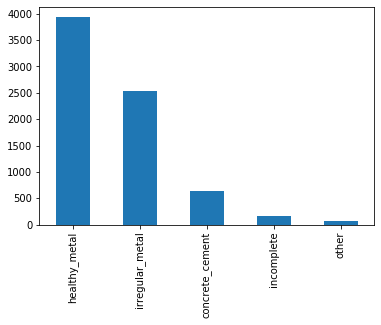

In [17]:
pred_df.drop(columns=['id'],inplace=True)
classes=pred_df.idxmax(axis=1)
pd.value_counts(classes).plot(kind="bar")